# Milestone 2: Feature Ready
Team C



In [5]:
pip install pyxlsb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
import joblib
import io

In [7]:
tqdm.pandas()


## Cek dataset awal
LIhat apakah kedua dataset yang diberikan sama

In [20]:
df1 = pd.read_excel('/content/ar-2010-2014-xlsb.xlsb',engine='pyxlsb')
df2 = pd.read_excel('/content/ar-2015-2016-xlsb.xlsb',engine='pyxlsb')

In [21]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337109 entries, 0 to 337108
Data columns (total 95 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Patient Age at Treatment                                                  337109 non-null  object 
 1   Date patient started trying to become pregnant OR date of last pregnancy  12274 non-null   float64
 2   Total Number of Previous cycles, Both IVF and DI                          337109 non-null  object 
 3   Total Number of Previous treatments, Both IVF and DI at clinic            337109 non-null  object 
 4   Total Number of Previous IVF cycles                                       337109 non-null  object 
 5   Total Number of Previous DI cycles                                        337109 non-null  object 
 6   Total number of previous pregnancies, Both IVF and D

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158519 entries, 0 to 158518
Data columns (total 95 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Patient Age at Treatment                                                  158519 non-null  object 
 1   Date patient started trying to become pregnant OR date of last pregnancy  617 non-null     float64
 2   Total Number of Previous cycles, Both IVF and DI                          158519 non-null  object 
 3   Total Number of Previous treatments, Both IVF and DI at clinic            158519 non-null  object 
 4   Total Number of Previous IVF cycles                                       158519 non-null  object 
 5   Total Number of Previous DI cycles                                        158519 non-null  object 
 6   Total number of previous pregnancies, Both IVF and D

Karena kedua dataset ternyata sama (hanya berbeda di tahun saja), maka keduanya akan digabungkan sehingga rentang dataset baru dari 2010-2016

In [23]:
frames = [df1, df2]
df_combined = pd.concat(frames)

## Feature selection
Sesuai dengan PRD, ada 3 dataset yang akan dibuat: 

1.   Sesuai dengan referensi [1], digunakan 25 fitur yang terdapat pada bagian "Without Feature Selection" 
2.   Masih memakai dengan referensi [1], digunakan 21 fitur yang terdapat pada bagian "With Feature Selection". Fitur dipilih dengan LinearSVC dari dataset 1. 
3.   Menggunakan fitur dengan referensi [2].



Dataset 1

In [29]:
selected_features_1 =["Live Birth Occurrence","Patient Age at Treatment","Total Number of Previous cycles, Both IVF and DI", "Total number of IVF pregnancies","Total number of live births - conceived through IVF","Type of Infertility - Female Primary",
"Type of Infertility - Female Secondary", "Type of Infertility - Male Primary","Type of Infertility - Male Secondary","Type of Infertility -Couple Primary","Type of Infertility -Couple Secondary",
"Cause  of Infertility - Tubal disease", "Cause of Infertility - Ovulatory Disorder","Cause of Infertility - Male Factor","Cause of Infertility - Patient Unexplained","Cause of Infertility - Endometriosis",
"Cause of Infertility - Cervical factors","Cause of Infertility - Female Factors","Cause of Infertility - Partner Sperm Concentration","Cause of Infertility -  Partner Sperm Morphology","Causes of Infertility - Partner Sperm Motility","Cause of Infertility -  Partner Sperm Immunological factors",
"Stimulation used","Egg Source","Sperm From","Fresh Cycle","Frozen Cycle","Eggs Mixed With Partner Sperm","Eggs Thawed","Embryos Transfered","Fresh Eggs Collected"]

In [30]:
dataset_1 = df_combined[selected_features_1]
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495628 entries, 0 to 158518
Data columns (total 31 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   Live Birth Occurrence                                        119210 non-null  float64
 1   Patient Age at Treatment                                     495628 non-null  object 
 2   Total Number of Previous cycles, Both IVF and DI             495628 non-null  object 
 3   Total number of IVF pregnancies                              495628 non-null  object 
 4   Total number of live births - conceived through IVF          495628 non-null  int64  
 5   Type of Infertility - Female Primary                         495628 non-null  int64  
 6   Type of Infertility - Female Secondary                       495628 non-null  int64  
 7   Type of Infertility - Male Primary                           4956

Feature Engineering
Ubah teks dan umur pada fitur menjadi categorical data.  
*   Patient Age at Treatment: Buang baris yang tidak dalam range. Konversi umur: 18-34=0, 35-37=1, 38-39=2, 40-42=3, 43-44=4, 45-50=5
*   Sperm From dan Egg source: Patient, Partner=1.  Donor, Partner & Donor = 0  
*   Stimulation used: buang data jika nilai 0



In [32]:
dataset_1 = dataset_1.dropna(subset = ["Egg Source","Sperm From"])
dataset_1 = dataset_1[dataset_1['Stimulation used'] != 0]
#Convert patient age to categorical data
dataset_1 = dataset_1[dataset_1['Patient Age at Treatment'] != "999"]
dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace(" ","")
dataset_1 = dataset_1.replace("> 50","50")
dataset_1 = dataset_1.replace(">=5","5")
#dataset_1["Patient Age at Treatment"] = dataset_1.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","44-50": "5"}})
dataset_1["Patient Age at Treatment"] = dataset_1.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","44-50": "5"}})
dataset_1 = dataset_1.replace("Patient","1")
dataset_1 = dataset_1.replace("Partner","1")
dataset_1 = dataset_1.replace("Donor","0")
dataset_1 = dataset_1.replace("Partner & Donor","0")
dataset_1 = dataset_1[dataset_1["Sperm From"].str.contains("not assigned")==False]


ValueError: ignored

Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [ ]:
dataset_1_X = dataset_1.loc[:, dataset_1.columns != "Live Birth Occurrence"]
dataset_1_Y = dataset_1["Live Birth Occurrence"]
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(dataset_1_X, dataset_1_Y, test_size=0.3, random_state=42)

Tampilkan correlation matrix dari fitur pada dataset 1

In [ ]:
corr_mat1 = dataset_1_X.corr().round(2)
sns.heatmap(corr_mat1, annot=True)
plt.show()

Dataset 2
Menggunakan fitur dari dataset 1, buat dataset baru dengan linearSVC untuk mengurangi jumlah fitur

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(dataset_1_X, dataset_1_Y)
model = SelectFromModel(lsvc, prefit=True)
dataset_2_X = model.transform(dataset_1_X)
dataset_2_Y = model.transform(dataset_1_Y)


c:\Users\mhpra\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


(333532, 21)

Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [ ]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(dataset_2_X, dataset_2_Y, test_size=0.3, random_state=42)

Tampilkan correlation matrix dari fitur pada dataset 2

In [ ]:
corr_mat2 = dataset_2_X.corr().round(2)
sns.heatmap(corr_mat2, annot=True)
plt.show()

Dataset 3
Cara yang sama dengan dataset 1, hanya berbeda dari fitur yang dipakai

In [33]:
selected_features_2 =["Live Birth Occurrence","Patient Age at Treatment", "Total Number of Previous treatments, Both IVF and DI at clinic", "Total Number of Previous IVF cycles","Total number of IVF pregnancies","Type of Infertility - Female Primary",
"Type of Infertility - Female Secondary", "Type of Infertility - Male Primary","Type of Infertility - Male Secondary","Type of Infertility -Couple Primary","Type of Infertility -Couple Secondary",
"Cause  of Infertility - Tubal disease", "Cause of Infertility - Ovulatory Disorder","Cause of Infertility - Male Factor","Cause of Infertility - Patient Unexplained","Cause of Infertility - Endometriosis",
"Cause of Infertility - Cervical factors","Cause of Infertility - Female Factors","Cause of Infertility - Partner Sperm Concentration","Cause of Infertility -  Partner Sperm Morphology","Causes of Infertility - Partner Sperm Motility","Cause of Infertility -  Partner Sperm Immunological factors",
"Stimulation used","Embryos Transfered","Type of treatment - IVF or DI","Specific treatment type","Total Embryos Created" ]

In [ ]:
dataset_3 = df_combined[selected_features_2]
dataset_3.info()

In [ ]:
dataset_3 = dataset_3.dropna(subset = ["Egg Source","Sperm From"])
dataset_3 = dataset_3[dataset_3['Stimulation used'] != 0]
#Convert patient age to categorical data
dataset_3 = dataset_3[dataset_3['Patient Age at Treatment'] != "999"]
dataset_3["Patient Age at Treatment"] = dataset_3["Patient Age at Treatment"].str.replace(" ","")
dataset_3 = dataset_3.replace("> 50","50")
dataset_3 = dataset_3.replace(">=5","5")
#dataset_1["Patient Age at Treatment"] = dataset_1.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","44-50": "5"}})
dataset_3["Patient Age at Treatment"] = dataset_3.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","44-50": "5"}})
dataset_3 = dataset_3.replace("Patient","1")
dataset_3 = dataset_3.replace("Partner","1")
dataset_3 = dataset_3.replace("Donor","0")
dataset_3 = dataset_3.replace("Partner & Donor","0")
dataset_3 = dataset_3[dataset_3["Sperm From"].str.contains("not assigned")==False]


Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [ ]:
dataset_3_X = dataset_3.loc[:, dataset_1.columns != "Live Birth Occurrence"]
dataset_3_Y = dataset_3["Live Birth Occurrence"]
from sklearn.model_selection import train_test_split
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(dataset_3_X, dataset_3_Y, test_size=0.3, random_state=42)

Tampilkan correlation matrix dari fitur pada dataset 3

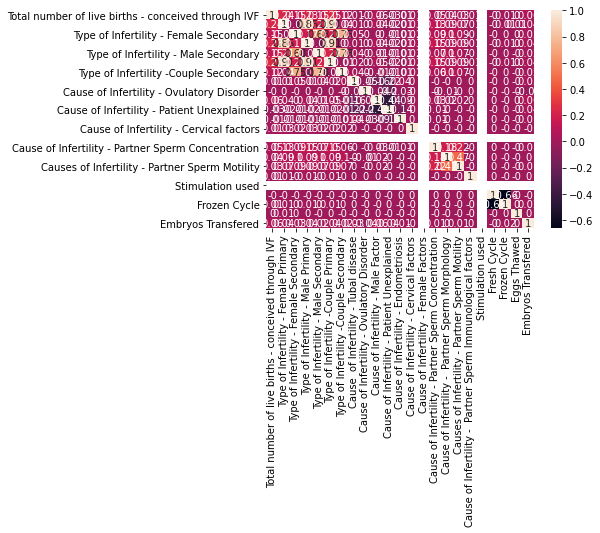

In [ ]:
corr_mat3 = dataset_3_X.corr().round(2)
sns.heatmap(corr_mat3, annot=True)
plt.show()